In [3]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
#from tqdm import tqdm_notebook
from lightgbm import LGBMRegressor
#from joblib import Parallel, delayed
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [70]:
data=pd.read_csv("fields_w_additional_info.csv")
data.head()

,Field_ID,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_ocs_0-30cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,...,climate_2019_12_pr,climate_2019_12_ro,climate_2019_12_soil,climate_2019_12_srad,climate_2019_12_swe,climate_2019_12_tmmn,climate_2019_12_tmmx,climate_2019_12_vap,climate_2019_12_vpd,climate_2019_12_vs
0,MH2O0YH,118.0,257.0,85.0,463.0,2458.0,323.0,57.0,59.0,308.0,...,125.0,6.0,215.0,1880.0,0.0,100.0,267.0,1680.0,69.0,210.0
1,O9TURWL,120.0,288.0,84.0,462.0,2108.0,306.0,58.0,61.0,243.0,...,126.0,6.0,215.0,1883.0,0.0,99.0,273.0,1682.0,75.0,190.0
2,35AFSDD,120.0,263.0,102.0,495.0,1991.0,288.0,58.0,60.0,271.0,...,135.0,7.0,289.0,1875.0,0.0,100.0,274.0,1690.0,76.0,200.0
3,PM05EG9,122.0,206.0,66.0,431.0,2432.0,337.0,65.0,57.0,332.0,...,121.0,6.0,189.0,1898.0,0.0,98.0,263.0,1688.0,64.0,210.0
4,V7PZBCG,124.0,167.0,116.0,439.0,566.0,302.0,53.0,56.0,326.0,...,194.0,66.0,1214.0,1930.0,0.0,143.0,291.0,1972.0,87.0,270.0


In [71]:
# Selecting only soil data
info_cols = data.filter(like = '5-15cm').columns.tolist() + ['Field_ID']
info = data[info_cols]
info.head()

,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean,Field_ID
0,118.0,257.0,85.0,463.0,2458.0,323.0,59.0,308.0,229.0,330.0,MH2O0YH
1,120.0,288.0,84.0,462.0,2108.0,306.0,61.0,243.0,295.0,280.0,O9TURWL
2,120.0,263.0,102.0,495.0,1991.0,288.0,60.0,271.0,234.0,284.0,35AFSDD
3,122.0,206.0,66.0,431.0,2432.0,337.0,57.0,332.0,237.0,335.0,PM05EG9
4,124.0,167.0,116.0,439.0,566.0,302.0,56.0,326.0,235.0,187.0,V7PZBCG


In [72]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

In [73]:
df=pd.read_csv("Train.csv")
df.head()

,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [74]:
info.shape


(4032, 11)

In [75]:
quality_1, quality_2, quality_3, = df[df.Quality == 1].index, df[df.Quality == 2].index, df[df.Quality == 3].index


In [76]:
df.Quality.value_counts()


3    1321
2    1231
1     425
Name: Quality, dtype: int64

In [77]:
df.Year.value_counts()


2017    1203
2016    1024
2019     569
2018     181
Name: Year, dtype: int64

In [78]:
df['path'] = ['image_arrays_train/' + x + '.npy' for x in df.Field_ID]
# test['path'] = ['image_arrays_test/' + x + '.npy' for x in test.Field_ID]
# target, year, quality = train.Yield, train.Year, train.Quality
df.head()

,Field_ID,Year,Quality,Yield,path
0,MH2O0YH,2019,3,3.686,image_arrays_train/MH2O0YH.npy
1,O9TURWL,2019,2,5.657,image_arrays_train/O9TURWL.npy
2,35AFSDD,2019,3,3.082,image_arrays_train/35AFSDD.npy
3,PM05EG9,2019,2,2.707,image_arrays_train/PM05EG9.npy
4,V7PZBCG,2019,2,2.679,image_arrays_train/V7PZBCG.npy


# data analysis and  exploration

In [79]:
df.shape

(2977, 5)

In [80]:
#reading the inputs from the npy files
field_id=df["Field_ID"].sample().values[0]
#getting the filename based on the id
filename=f"image_arrays_train/{field_id}.npy"
print(filename)
#loading the data fom the npy file
data=np.load(filename)
print(data[0])
print(data.shape)

image_arrays_train/IBBNPHV.npy
[[1136 1136 1136 ... 1094 1094 1094]
 [1136 1136 1136 ... 1094 1094 1094]
 [1136 1136 1136 ... 1094 1094 1094]
 ...
 [1128 1128 1128 ... 1117 1117 1117]
 [1128 1128 1128 ... 1117 1117 1117]
 [1192 1192 1192 ... 1107 1107 1107]]
(360, 41, 40)


# showing visible bands

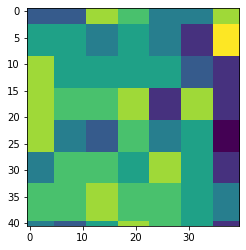

In [81]:
#displaying a single band
june=(data[10])
#scainng the image fr easy display
june=june/np.max(june)
plt.imshow(june)

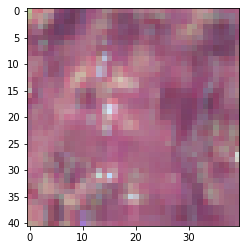

In [82]:
#combining 3bands for a certain month
jan=np.stack([data[4],data[3],data[2]],axis=-1)
#scainng the image fr easy display
jan=jan/np.max(jan)
plt.imshow(jan)

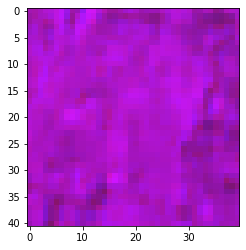

In [83]:

#combining 3bands for a certain month
jan=np.stack([data[5],data[359],data[7]],axis=-1)
#scainng the image fr easy display
jan=jan/np.max(jan)
plt.imshow(jan)

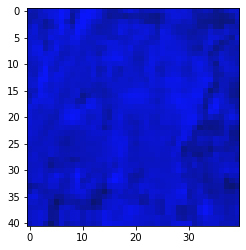

In [84]:
#showing visible bands
#combining 3bands for a certain month
dec=np.stack([data[55],data[359],data[7]],axis=-1)
#scainng the image fr easy display
dec=dec/np.max(dec)
plt.imshow(dec)

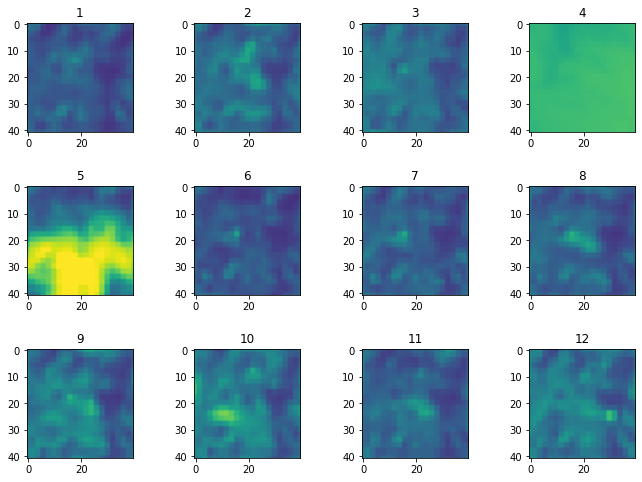

In [85]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = data[i*30 + 12]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

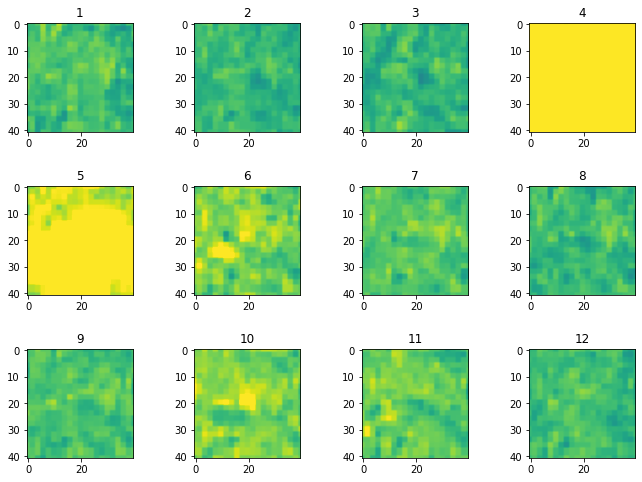

In [86]:
# Show the SWIR band (B6) where healthy and unhealthy vegetation
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = data[i*30 + 6]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

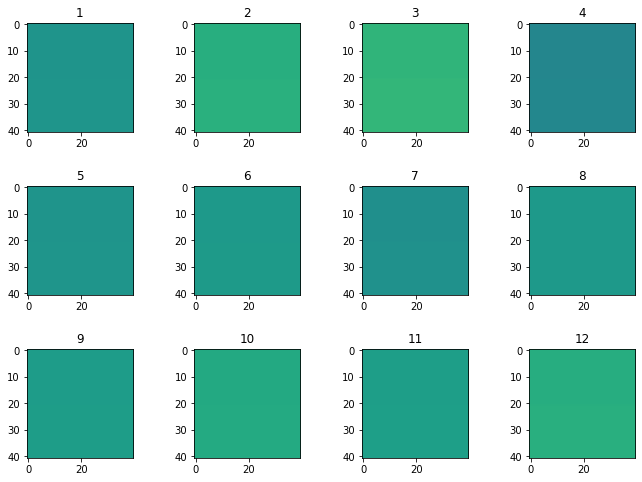

In [87]:
# Show the CLIM(23) where there are soil variable
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = data[i*30 + 23]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

In [88]:
main_bands = ['S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil', 'S2_B8', 'S2_B11']

def process_im(path, bands=main_bands):
  arr = np.load(path)
  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    vs = arr[idxs, 20, 20] # Sample the img at the center point
    for bn, v in zip(bns, vs[0]):
      values[bn] = v
    
  return values

comb = pd.DataFrame(process_im(x) for x in df.path.values)

In [89]:
comb = comb**(1/2.0)


In [90]:
comb.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,0_S2_B8,0_S2_B11,1_S2_B5,1_S2_B4,...,10_S2_B8,10_S2_B11,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,11_S2_B8,11_S2_B11
0,30.561414,30.528675,34.249088,37.309516,45.144213,53.916602,2.000000,16.941074,31.859065,32.186954,...,9.110434,9.643651,27.276363,26.438608,19.824228,28.106939,42.953463,31.384710,11.180340,14.662878
1,29.664794,28.653098,30.397368,33.406586,44.170126,49.030603,2.000000,16.941074,30.545049,29.546573,...,8.831761,9.797959,26.514147,22.891046,17.972201,20.493902,29.849623,21.656408,11.224972,14.662878
2,31.874755,32.710854,36.837481,40.398020,46.227697,59.724367,2.000000,16.673332,33.286634,34.539832,...,8.660254,9.643651,54.175640,54.415071,59.983331,64.381674,64.598762,69.985713,11.618950,17.000000
3,27.874720,28.000000,25.278449,32.619013,50.872389,46.076024,1.732051,17.291616,28.844410,29.580399,...,9.273618,9.746794,85.375641,85.959293,89.582364,89.760793,92.994624,86.058120,11.000000,13.747727
4,32.878564,33.496268,34.088121,38.561639,51.019604,54.644304,4.472136,20.663978,32.341923,32.603681,...,11.045361,33.511192,32.465366,33.120990,28.089144,36.728735,58.779248,49.274740,13.928388,34.842503


In [91]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
new = info.drop(info[['Field_ID']], axis=1)
info_scaled = pd.DataFrame(scaler.fit_transform(new), columns = new.columns )
info_scaled['Field_ID'] = info.Field_ID
info_scaled

,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean,Field_ID
0,0.652174,0.646586,0.368687,0.505181,0.405593,0.464684,0.333333,0.500000,0.262997,0.448141,MH2O0YH
1,0.681159,0.771084,0.363636,0.502591,0.332002,0.401487,0.416667,0.334184,0.464832,0.350294,O9TURWL
2,0.681159,0.670683,0.454545,0.588083,0.307401,0.334572,0.375000,0.405612,0.278287,0.358121,35AFSDD
3,0.710145,0.441767,0.272727,0.422280,0.400126,0.516729,0.250000,0.561224,0.287462,0.457926,PM05EG9
4,0.739130,0.285141,0.525253,0.443005,0.007780,0.386617,0.208333,0.545918,0.281346,0.168297,V7PZBCG
...,...,...,...,...,...,...,...,...,...,...,...
4027,0.550725,0.618474,0.323232,0.474093,0.274601,0.594796,0.291667,0.290816,0.553517,0.518591,3H89LWV
4028,0.565217,0.502008,0.500000,0.463731,0.239487,0.587361,0.125000,0.318878,0.525994,0.461840,I6EYSGB
4029,0.652174,0.433735,0.621212,0.365285,0.145500,0.278810,0.166667,0.357143,0.599388,0.334638,XOEIR44
4030,0.695652,0.465863,0.388889,0.580311,0.196173,0.271375,0.250000,0.410714,0.281346,0.211350,YB307JG


In [2]:
comb['Field_ID'] = df.Field_ID.reset_index(drop = True)
comb = comb.merge(info_scaled, how = 'left', left_on=['Field_ID'],
                  right_on=['Field_ID'])
comb = comb.drop('Field_ID', axis = 1)


NameError: name 'df' is not defined

In [93]:
comb

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,0_S2_B8,0_S2_B11,1_S2_B5,1_S2_B4,...,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean
0,30.561414,30.528675,34.249088,37.309516,45.144213,53.916602,2.000000,16.941074,31.859065,32.186954,...,0.652174,0.646586,0.368687,0.505181,0.405593,0.464684,0.333333,0.500000,0.262997,0.448141
1,29.664794,28.653098,30.397368,33.406586,44.170126,49.030603,2.000000,16.941074,30.545049,29.546573,...,0.681159,0.771084,0.363636,0.502591,0.332002,0.401487,0.416667,0.334184,0.464832,0.350294
2,31.874755,32.710854,36.837481,40.398020,46.227697,59.724367,2.000000,16.673332,33.286634,34.539832,...,0.681159,0.670683,0.454545,0.588083,0.307401,0.334572,0.375000,0.405612,0.278287,0.358121
3,27.874720,28.000000,25.278449,32.619013,50.872389,46.076024,1.732051,17.291616,28.844410,29.580399,...,0.710145,0.441767,0.272727,0.422280,0.400126,0.516729,0.250000,0.561224,0.287462,0.457926
4,32.878564,33.496268,34.088121,38.561639,51.019604,54.644304,4.472136,20.663978,32.341923,32.603681,...,0.739130,0.285141,0.525253,0.443005,0.007780,0.386617,0.208333,0.545918,0.281346,0.168297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,32.557641,34.871192,35.930488,39.824616,53.263496,54.479354,8.944272,23.706539,34.161382,36.359318,...,0.724638,0.269076,0.585859,0.458549,0.133095,0.267658,0.208333,0.423469,0.409786,0.242661
2973,30.854497,31.843367,30.099834,34.713110,53.432200,47.581509,8.544004,22.803509,33.090784,33.941125,...,0.666667,0.273092,0.575758,0.468912,0.231707,0.401487,0.250000,0.418367,0.403670,0.281800
2974,29.899833,30.512293,28.231188,34.583233,49.517674,49.457052,8.888194,24.799194,31.859065,31.937439,...,0.753623,0.261044,0.545455,0.549223,0.141926,0.260223,0.208333,0.397959,0.333333,0.197652
2975,30.282008,31.416556,30.789609,36.428011,55.272054,51.497573,6.164414,21.213203,30.347982,31.496031,...,0.652174,0.694779,0.560606,0.331606,0.163583,0.405204,0.375000,0.474490,0.498471,0.348337


In [94]:
comb['Yield'] = df.Yield

In [95]:
comb.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,0_S2_B8,0_S2_B11,1_S2_B5,1_S2_B4,...,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean,Yield
0,30.561414,30.528675,34.249088,37.309516,45.144213,53.916602,2.000000,16.941074,31.859065,32.186954,...,0.646586,0.368687,0.505181,0.405593,0.464684,0.333333,0.500000,0.262997,0.448141,3.686
1,29.664794,28.653098,30.397368,33.406586,44.170126,49.030603,2.000000,16.941074,30.545049,29.546573,...,0.771084,0.363636,0.502591,0.332002,0.401487,0.416667,0.334184,0.464832,0.350294,5.657
2,31.874755,32.710854,36.837481,40.398020,46.227697,59.724367,2.000000,16.673332,33.286634,34.539832,...,0.670683,0.454545,0.588083,0.307401,0.334572,0.375000,0.405612,0.278287,0.358121,3.082
3,27.874720,28.000000,25.278449,32.619013,50.872389,46.076024,1.732051,17.291616,28.844410,29.580399,...,0.441767,0.272727,0.422280,0.400126,0.516729,0.250000,0.561224,0.287462,0.457926,2.707
4,32.878564,33.496268,34.088121,38.561639,51.019604,54.644304,4.472136,20.663978,32.341923,32.603681,...,0.285141,0.525253,0.443005,0.007780,0.386617,0.208333,0.545918,0.281346,0.168297,2.679


In [96]:
comb.to_csv('satelite.csv', index=False)

In [1]:
X, y  = comb[comb.columns[:-1]], comb['Yield']
folds = KFold(n_splits = 5)

# Dataframe to store feature importance for each fold
feature_importance_df = pd.DataFrame()
from sklearn.metrics import r2_score

predictions = []
r2_ = []
for i,( train_index, test_index) in enumerate(folds.split(X, y)):
  # Good quality data split - X_test, y_test to be used for validation only
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    model = LGBMRegressor(n_estimators=400, eval_metric = 'r2_score', learning_rate=0.1, reg_alpha=2)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())
    
    wrapped_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    
    y_pred = wrapped_model.predict(X_test)



    # Calculating the r2_score for each fold
    r2 = r2_score(y_test, y_pred)
    print(f"the r2_score is:{r2}")




NameError: name 'comb' is not defined